In [1]:
import numpy as np
import audioflux as af
from audioflux.type import SpectralFilterBankScaleType
import math
from IPython.display import Audio, display, Image, HTML
import matplotlib.pyplot as plt
from audioflux.display import fill_spec
import PIL
from prototyping import *
from dtw import dtw
from numpy.linalg import norm
import librosa
import os
plt.rcParams['figure.dpi'] = 100

In [2]:
def get_spectrogram(audio_arr):
    # Create BFT object and extract mel spectrogram
    bft_obj = af.BFT(num=128, radix2_exp=12, samplate=SAMPLE_RATE,
                     scale_type=SpectralFilterBankScaleType.MEL)

    spec_arr = bft_obj.bft(audio_arr)
    spec_arr = np.abs(spec_arr)
    return bft_obj, spec_arr

def show_spectrogram(audio_len: int, bft_obj, spec_arr, ax):
    img = fill_spec(spec_arr, axes=ax,
              x_coords=bft_obj.x_coords(audio_len),
              y_coords=bft_obj.y_coords(),
              x_axis='time', y_axis='log',
              title='Mel Spectrogram')
    # fig.colorbar(img, ax=ax)


Target sample rate 22050
Generator sample rate 22050


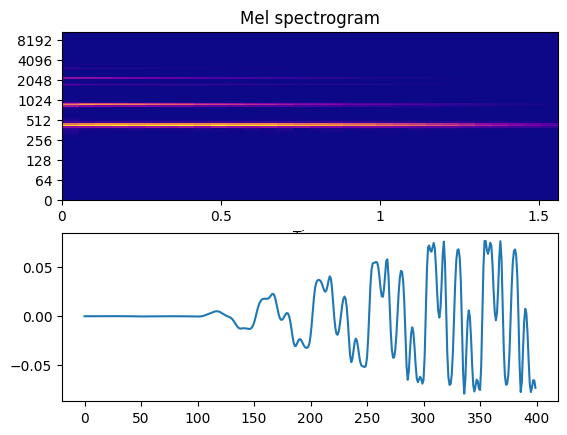

In [3]:
fm_sample_data, fm_sample_sample_rate = librosa.load('./fm_sample.wav')
print("Target sample rate", fm_sample_sample_rate)
print("Generator sample rate", SAMPLE_RATE)

fm_sample = Sample(fm_sample_data)

fig, (ax, ax2) = plt.subplots(2, 1, sharex=False, sharey=False)
fm_sample.plot_spectrogram(ax)
ax2.plot(fm_sample.buffer[:400])

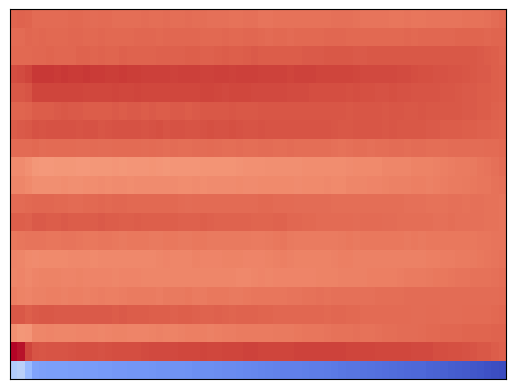

In [4]:
# fm_sample_mfcc = fm_sample.mfcc
librosa.display.specshow(fm_sample.mfcc)
Audio(data=fm_sample.buffer, rate=SAMPLE_RATE)
# print(fm_sample_sample_rate)

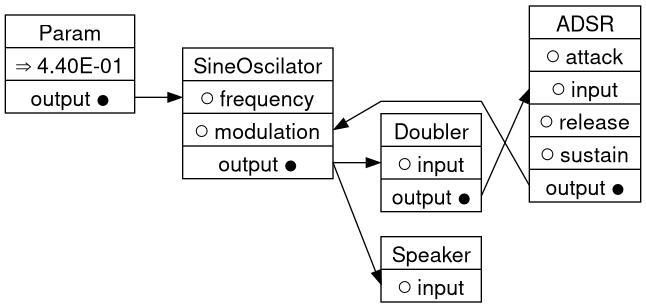

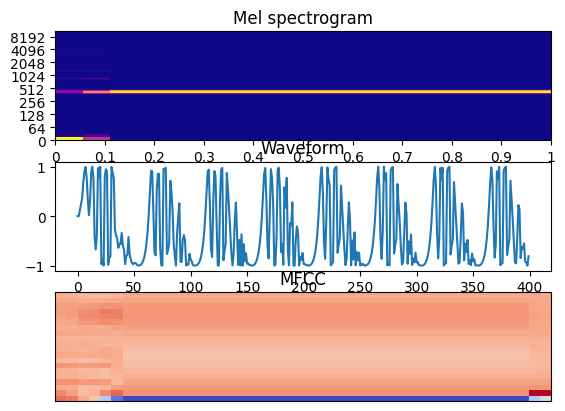

In [5]:
graph = get_starting_graph()

# add_adsr_between(graph, 1, 0)


def get_node_of_type(graph, node_type):
    for node_handle, node in graph.nodes.items():
        if isinstance(node, node_type):
            return node_handle

sine = get_node_of_type(graph, SineOscilator)
# sine = get_node_of_type(graph, SineOscilator)
doubler = graph.add_node(Doubler())
# graph.connections.pop(1)
graph.patch(sine, "output", doubler, "input")
adsr = graph.add_node(ADSR())
graph.patch(doubler, "output", adsr, "input")
graph.patch(adsr, "output", sine, "modulation")

graph.nodes[adsr].inputs.decay =   0.0001

# graph.patch
# graph.nodes[]
# randomize_random_param(graph)
# randomize_random_param(graph)
# randomize_random_param(graph)
# randomize_random_param(graph)

generated_sample = graph.play(SAMPLE_RATE * 1)

fig, (ax1, ax2, ax3) = plt.subplots(3, 1, sharex=False, sharey=False)

generated_sample.plot_spectrogram(ax1)

generated_sample.plot_mfcc(ax3)
generated_sample.plot_waveform(ax2)

display(Image(graph.draw()))

# display(Audio(data=audio_arr, rate=SAMPLE_RATE))
generated_sample.show_audio()

2 1 1 0
1 0 1 0
removing


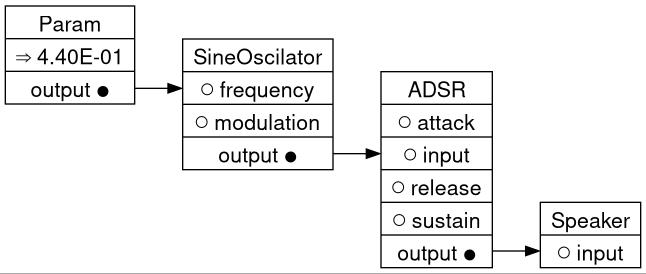

In [6]:
graph = get_starting_graph()


def add_adsr_between(graph: DspGraph, output_node: NodeId, input_node: NodeId) -> Optional[NodeId]:
    for connection in graph.connections:
        print(connection.from_node, connection.to_node, output_node, input_node)
        if connection.from_node == output_node and connection.to_node == input_node:
            print("removing")
            graph.connections.remove(connection)
            break
            
    new_adsr = graph.add_node(ADSR())
    graph.patch( output_node, "output", new_adsr, "input")
    graph.patch(new_adsr, "output", input_node, "input")
        
        
add_adsr_between(graph, 1, 0)

Image(graph.draw())

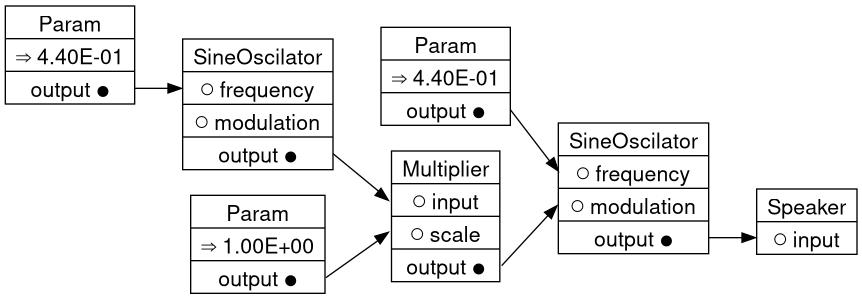

AttributeError: 'Sample' object has no attribute 'show_player'

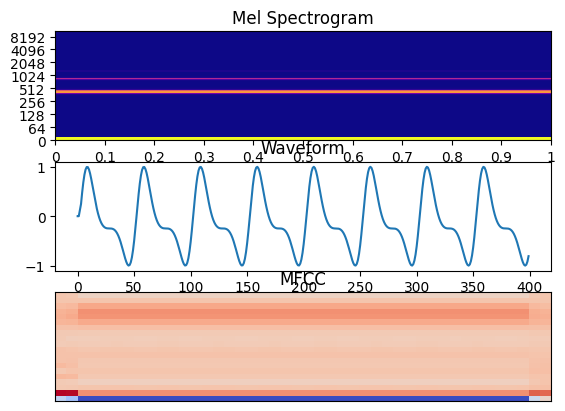

In [12]:
def make_simple_fm(mod_freq, mod_strength) -> DspGraph:
    graph = get_starting_graph()

    modulator = graph.add_node(SineOscilator())
    mod_mult = graph.add_node(Multiplier())

    _mod_freq = Param()
    _mod_scale = Param()
    _mod_scale.set_value(mod_strength)
    _mod_freq.set_value(mod_freq)
    
    mod_freq = graph.add_node(_mod_freq)
    mod_strength = graph.add_node(_mod_scale)

    graph.patch(mod_strength, "output", mod_mult, "scale")
    graph.patch(mod_freq, "output", modulator, "frequency")
    graph.patch(modulator, "output", mod_mult, "input")
    graph.patch(mod_mult, "output", 1, "modulation")

    return graph, mod_strength, mod_freq

graph, mod_strength, mod_freq = make_simple_fm(.440, 1.0)
Image(graph.draw())

# audio_arr = np.zeros(SAMPLE_RATE * 1)
# for i in range(len(audio_arr)):
#     # graph.nodes[mod_strength].set_value( graph.nodes[mod_strength].get_value() + 0.0001 )
#     # graph.nodes[mod_freq].set_value( graph.nodes[mod_freq].get_value() - 0.00001 )
#     audio_arr[i] = graph.tick()

generated_audio = graph.play(num_samples = SAMPLE_RATE * 1)
    
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, sharex=False, sharey=False)

bft_obj, spec_arr = generated_audio.spectrogram
show_spectrogram(len(generated_audio), bft_obj, spec_arr, ax1)

ax3.set_title("MFCC")
librosa.display.specshow(generated_audio.mfcc, ax=ax3)

# ax2.set_title("Waveform")
# ax2.plot(audio_arr[:400])
generated_audio.plot_waveform(ax2)

# plt.show()
display(Image(graph.draw()))

# display(Audio(data=audio_arr, rate=SAMPLE_RATE))
generated_audio.show_player()

# target_sample = audio_arr
# target_sample_mfcc = generated_sample_mfcc

In [ ]:
plus_minus = 4
base = 440
mod_freqs = [ a/1000 for a in range(200, 800, 20) ]
mod_strengths = [ a / 100 for a in range(0, 200, 25) ]

# mod_freqs = [ 0, 0.1, 0.440, 1.2 ] 
# mod_strengths = [ 1.0 ]
results = np.zeros((len(mod_freqs), len(mod_strengths)))

for freq_index, freq in enumerate(mod_freqs):
    for mod_index, mod_strength in enumerate(mod_strengths):     
        graph, _, _ = make_simple_fm(freq, mod_strength)
        audio_arr = np.zeros(SAMPLE_RATE * 1)
        for i in range(len(audio_arr)):
            audio_arr[i] = graph.tick()
            
        generated_audio_mfcc = librosa.feature.mfcc(y=audio_arr, sr=SAMPLE_RATE)
        dist, cost, acc_cost, path = dtw(target_sample_mfcc.T, generated_audio_mfcc.T, dist=lambda x, y: norm(x - y, ord=1))
        # print(freq, mod_strength, ":", dist)
        
        results[freq_index][mod_index] = dist
    

In [ ]:
fig, ax = plt.subplots()

im = ax.imshow(results)

# Show all ticks and label them with the respective list entries
ax.set_xticks(np.arange(len(mod_strengths)), labels=mod_strengths)

plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")
ax.set_yticks(np.arange(len(mod_freqs)), labels=mod_freqs)
ax.set_ylabel("Modulation frequency")
ax.set_xlabel("Modulation strength")

fig.tight_layout()

In [ ]:
# mod_freqs = [ a/1000 for a in range(400, 600, 40) ]
mod_strengths = [ a / 100 for a in range(0, 200, 10) ]

# mod_freqs = [ 0, 0.1, 0.440, 1.2 ] 
# mod_strengths = [ 1.0 ]
# results = np.zeros((len(mod_freqs), len(mod_strengths)))
results = []

# for freq_index, freq in enumerate(mod_freqs):
for mod_index, mod_strength in enumerate(mod_strengths):
    graph, _, _ = make_simple_fm(.440, mod_strength)
    audio_arr = np.zeros(SAMPLE_RATE * 1)
    for i in range(len(audio_arr)):
        audio_arr[i] = graph.tick()

    generated_audio_mfcc = librosa.feature.mfcc(y=audio_arr, sr=SAMPLE_RATE)
    dist, cost, acc_cost, path = dtw(target_sample_mfcc.T, generated_audio_mfcc.T, dist=lambda x, y: norm(x - y, ord=1))
    # print(freq, mod_strength, ":", dist)

    # results[freq_index][mod_index] = dist
    results.append(dist)
    
plt.plot( mod_strengths, results )

In [ ]:
mod_freqs = [ a/1000 for a in range(200, 800, 10) ]
# mod_strengths = [ a / 100 for a in range(0, 200, 1) ]

print(mod_freqs)

# # mod_freqs = [ 0, 0.1, 0.440, 1.2 ] 
# # mod_strengths = [ 1.0 ]
# # results = np.zeros((len(mod_freqs), len(mod_strengths)))
results = []

for freq_index, freq in enumerate(mod_freqs):
# for mod_index, mod_strength in enumerate(mod_strengths):
    graph, _, _ = make_simple_fm(freq, 1.0)
    audio_arr = np.zeros(SAMPLE_RATE * 1)
    for i in range(len(audio_arr)):
        audio_arr[i] = graph.tick()

    generated_audio_mfcc = librosa.feature.mfcc(y=audio_arr, sr=SAMPLE_RATE)
    dist, cost, acc_cost, path = dtw(target_sample_mfcc.T, generated_audio_mfcc.T, dist=lambda x, y: norm(x - y, ord=1))
    # print(freq, mod_strength, ":", dist)

    # results[freq_index][mod_index] = dist
    results.append(dist)
    
plt.plot( mod_freqs, results )

In [ ]:
harvest = np.array([[0.8, 2.4, 2.5, 3.9, 0.0, 4.0, 0.0],
                    [2.4, 0.0, 4.0, 1.0, 2.7, 0.0, 0.0],
                    [1.1, 2.4, 0.8, 4.3, 1.9, 4.4, 0.0],
                    [0.6, 0.0, 0.3, 0.0, 3.1, 0.0, 0.0],
                    [0.7, 1.7, 0.6, 2.6, 2.2, 6.2, 0.0],
                    [1.3, 1.2, 0.0, 0.0, 0.0, 3.2, 5.1],
                    [0.1, 2.0, 0.0, 1.4, 0.0, 1.9, 6.3]])


fig, ax = plt.subplots()

im = ax.imshow(harvest)